In [ ]:
# necessary imports
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import joblib



In [8]:
# establish connection to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading JSON files: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]
<ipython-input-18-2e85787d6e8a>:68: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)


Data processed. Time range: 2024-01-02 09:30:00-05:00 to 2024-12-31 16:00:00-05:00
Normalized DataFrame head:
                               open      high       low     close    volume  \
2024-01-02 09:30:00-05:00  0.265241  0.273863  0.260272  0.263291  3.608915   
2024-01-02 09:31:00-05:00  0.264126  0.263415  0.250638  0.252274  1.677099   
2024-01-02 09:32:00-05:00  0.252634  0.254360  0.252174  0.251298  0.991793   
2024-01-02 09:33:00-05:00  0.251178  0.248510  0.215317  0.214480  2.536603   
2024-01-02 09:34:00-05:00  0.214900  0.212629  0.197307  0.195931  1.874998   

                           sin_hour  cos_hour  sin_minute  cos_minute  \
2024-01-02 09:30:00-05:00  1.661895  1.590095    0.069269   -1.412409   
2024-01-02 09:31:00-05:00  1.661895  1.590095   -0.079101   -1.404671   
2024-01-02 09:32:00-05:00  1.661895  1.590095   -0.225845   -1.381544   
2024-01-02 09:33:00-05:00  1.661895  1.590095   -0.369356   -1.343280   
2024-01-02 09:34:00-05:00  1.661895  1.590095   -0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/100, Loss: 0.007548
Epoch 2/100, Loss: 0.001036
Epoch 3/100, Loss: 0.001010
Epoch 4/100, Loss: 0.000957
Epoch 5/100, Loss: 0.000924
Epoch 6/100, Loss: 0.000893
Epoch 7/100, Loss: 0.000835
Epoch 8/100, Loss: 0.000805
Epoch 9/100, Loss: 0.000755
Epoch 10/100, Loss: 0.000688
Epoch 11/100, Loss: 0.000627
Epoch 12/100, Loss: 0.000566
Epoch 13/100, Loss: 0.000563
Epoch 14/100, Loss: 0.000492
Epoch 15/100, Loss: 0.000475
Epoch 16/100, Loss: 0.000428
Epoch 17/100, Loss: 0.000405
Epoch 18/100, Loss: 0.000364
Epoch 19/100, Loss: 0.000347
Epoch 20/100, Loss: 0.000364
Epoch 21/100, Loss: 0.000303
Epoch 22/100, Loss: 0.000308
Epoch 23/100, Loss: 0.000269
Epoch 24/100, Loss: 0.000271
Epoch 25/100, Loss: 0.000248
Epoch 26/100, Loss: 0.000244
Epoch 27/100, Loss: 0.000225
Epoch 28/100, Loss: 0.000213
Epoch 29/100, Loss: 0.000190
Epoch 30/100, Loss: 0.000184
Epoch 31/100, Loss: 0.000183
Epoch 32/100, Loss: 0.000191
Epoch 33/100, Loss: 0.000164
Epoch 34/100, Loss: 0.000162
Epoch 35/100, Loss: 0.0

<ipython-input-18-2e85787d6e8a>:260: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')


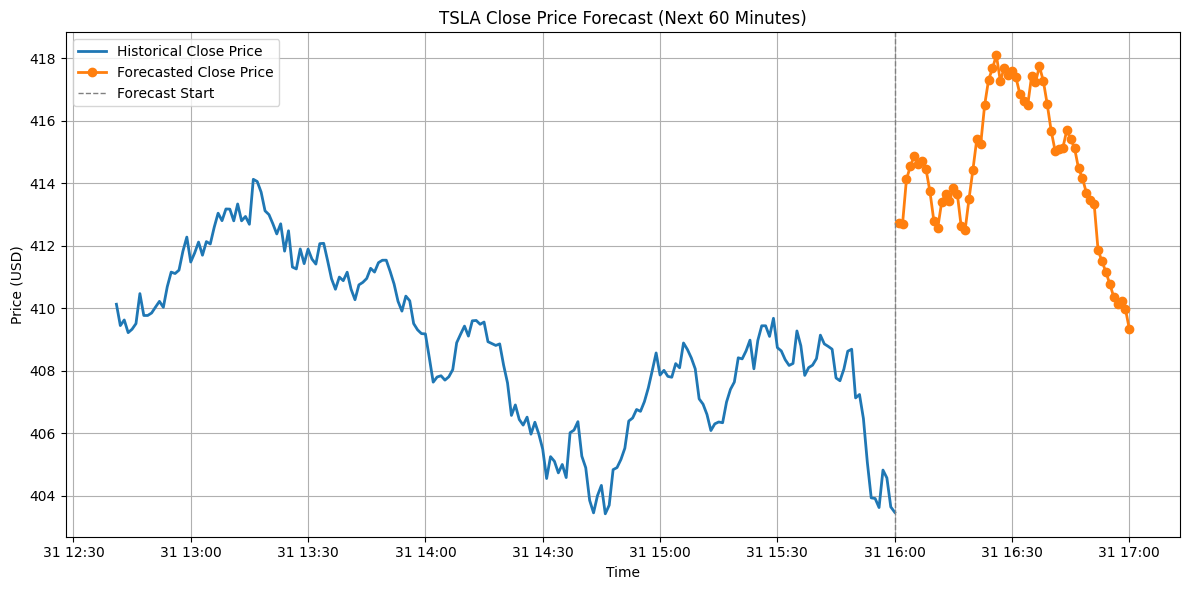

In [ ]:
stock_ticker = "TSLA"  # Das Aktiensymbol

#########################################
# 1. DATA LOADING, PROCESSING & FEATURE ENGINEERING
#########################################

def load_stock_data(file_pattern: str) -> pd.DataFrame:
    all_dfs = []
    files = glob.glob(file_pattern)
    for file in tqdm(files, desc="Loading JSON files"):
        if not os.path.basename(file).startswith(stock_ticker):
            continue
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                metadata = data["Meta Data"]
                symbol = metadata["2. Symbol"]
                interval = metadata["4. Interval"]
                if interval != "1min":
                    print(f"Warning: {file} has interval {interval} (expected '1min'). Skipping.")
                    continue
                ts_key = f"Time Series ({interval})"
                ts_data = data.get(ts_key)
                if not ts_data:
                    print(f"Warning: {ts_key} not found in {file}. Skipping.")
                    continue
                df = pd.DataFrame(ts_data).T
                df = df.apply(pd.to_numeric)
                df["symbol"] = symbol
                all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue
    if not all_dfs:
        raise ValueError("No valid data found in any files.")
    combined_df = pd.concat(all_dfs)
    combined_df.index = pd.to_datetime(combined_df.index)
    combined_df = combined_df.sort_index()
    combined_df.columns = [col.split(". ")[-1] for col in combined_df.columns]
    return combined_df

# Load minute-level data (z.B. Dateien wie "AAPL_2024-01.json")
raw_df = load_stock_data(f"drive/MyDrive/software-engineering/alphavantage/data/{stock_ticker}_*.json")

def process_stock_data(df: pd.DataFrame, fill_method: str = 'ffill',
                       filter_market_hours: bool = True, timezone: str = 'US/Eastern') -> pd.DataFrame:
    if df.index.tz is None:
        df.index = df.index.tz_localize(timezone)
    processed_dfs = []
    for symbol, group in df.groupby('symbol'):
        group = group[~group.index.duplicated(keep='last')]
        full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)
        group = group.reindex(full_range)
        group['symbol'] = symbol
        if fill_method == 'ffill':
            group = group.ffill()
        elif fill_method == 'bfill':
            group = group.bfill()
        elif fill_method == 'interpolate':
            group = group.interpolate()
        else:
            raise ValueError(f"Invalid fill_method: {fill_method}.")
        if filter_market_hours:
            group = group.between_time('09:30', '16:00')
        processed_dfs.append(group)
    processed_df = pd.concat(processed_dfs)
    return processed_df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if df.index.tz is None:
        df.index = df.index.tz_localize('US/Eastern')
    # Intraday cyclical features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
    # Daily features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year
    return df

processed_df = process_stock_data(raw_df, fill_method='ffill', filter_market_hours=True)
processed_df = add_time_features(processed_df)

# Optionale Speicherung und Überprüfung der verarbeiteten Daten
processed_df.to_csv("processed_stock_data.csv", index_label='timestamp')
print("Data processed. Time range:", processed_df.index.min(), "to", processed_df.index.max())

#########################################
# 2. NORMALIZATION
#########################################

# Definiere die Features in einer bestimmten Reihenfolge:
# Preisfelder (open, high, low, close, volume), dann intraday cyclical, dann daily.
features_to_normalize = ['open', 'high', 'low', 'close', 'volume',
                           'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute',
                           'day_of_week', 'day_of_month', 'month', 'day_of_year', 'year']

scaler = StandardScaler()
normalized_values = scaler.fit_transform(processed_df[features_to_normalize])
normalized_df = pd.DataFrame(normalized_values, columns=features_to_normalize, index=processed_df.index)
normalized_df['symbol'] = processed_df['symbol']
print("Normalized DataFrame head:")
print(normalized_df.head())
joblib.dump(scaler, "scaler_minute.pkl")

#########################################
# 3. SEQUENCE CREATION: DIRECT MULTI-STEP FORECASTING
#########################################

def create_sequences_multi(data: np.ndarray, window_size: int, forecast_horizon: int):
    """
    Erstelle Sequenzen, bei denen das Input die vergangenen 'window_size' Minuten sind
    und das Target ein Vektor der nächsten 'forecast_horizon' "close"-Werte ist.
    data: numpy array der Form (num_timesteps, num_features)
    Returns:
      X: Form (num_samples, window_size, num_features)
      y: Form (num_samples, forecast_horizon)
    """
    X, y = [], []
    # Hinweis: Der Feature-Index 3 entspricht "close"
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon, 3])
    return np.array(X), np.array(y)

WINDOW_SIZE = 60       # Vergangene 60 Minuten als Input
forecast_horizon = 60  # Vorhersage der nächsten 60 Minuten direkt

data_array = normalized_df[features_to_normalize].values
X_multi, y_multi = create_sequences_multi(data_array, WINDOW_SIZE, forecast_horizon)
print("X_multi shape:", X_multi.shape, "y_multi shape:", y_multi.shape)

#########################################
# 4. PYTORCH DATASET & MULTI-STEP LSTM MODEL
#########################################

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MultiStepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2):
        super(MultiStepLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Die finale Fully Connected Layer gibt einen Vektor der Länge forecast_horizon aus
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Verwende den Output des letzten Zeitschritts
        out = self.fc(out[:, -1, :])
        return out  # Form: (batch_size, forecast_horizon)

input_size = len(features_to_normalize)
hidden_size = 128
num_layers = 1
output_size = forecast_horizon  # wird nicht explizit verwendet; fc gibt forecast_horizon aus
model = MultiStepLSTMModel(input_size, hidden_size, num_layers, forecast_horizon, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#########################################
# 5. TRAINING DES MODELLS
#########################################

BATCH_SIZE = 64
EPOCHS = 100

dataset = StockDataset(X_multi, y_multi)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # (batch, WINDOW_SIZE, input_size)
        batch_y = batch_y.to(device)  # (batch, forecast_horizon)
        optimizer.zero_grad()
        output = model(batch_x)       # (batch, forecast_horizon)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# Optional: Möchtest du das Modell direkt in deinem Google Drive speichern (Drive gemountet in Colab),
# passe den Pfad wie folgt an:
drive_path = "drive/MyDrive/pecunia/trained_models"
os.makedirs(drive_path, exist_ok=True)
model_save_path = os.path.join(drive_path, f"trained_model_{stock_ticker}.pth")

torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

#########################################
# 6. FORECASTING (DIRECT MULTI-STEP)
#########################################

# Verwende die letzten WINDOW_SIZE Zeilen der normalisierten Daten als Input-Sequenz
last_sequence = data_array[-WINDOW_SIZE:]  # Form: (WINDOW_SIZE, num_features)
initial_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_norm = model(initial_sequence).cpu().numpy().flatten()  # Form: (forecast_horizon,)

# Inverse-Transformation der vorhergesagten normalisierten "close"-Werte.
# Es wird ein Platzhalter-Array für jeden vorhergesagten Schritt mit der korrekten Anzahl an Features erstellt.
pred_placeholder = np.zeros((len(predicted_norm), len(features_to_normalize)))
# Setze die "close"-Spalte (Index 3) auf den vorhergesagten normalisierten Wert.
pred_placeholder[:, 3] = predicted_norm
# Inverse transformieren mittels des Scalers. Nur die "close"-Spalte ist hierbei von Bedeutung.
predicted_prices = scaler.inverse_transform(pred_placeholder)[:, 3]
print("Predicted Prices (Original Scale):", predicted_prices)

#########################################
# 7. PLOTTING DER PREDICTIONS
#########################################

# Plot der letzten 200 Minuten historischer Close-Preise und Overlay der Vorhersage.
historical_data = processed_df[['close']].iloc[-200:]
# Erstelle einen Zeitbereich für die Vorhersage (nächste 60 Minuten)
last_time = historical_data.index[-1]
forecast_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=forecast_horizon, freq='T')

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['close'], label="Historical Close Price", lw=2)
plt.plot(forecast_times, predicted_prices, label="Forecasted Close Price", lw=2, marker='o')
plt.axvline(x=historical_data.index[-1], color="gray", linestyle="--", lw=1, label="Forecast Start")
plt.title(f"{stock_ticker} Close Price Forecast (Next 60 Minutes)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()